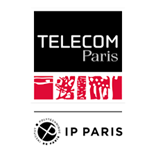

# Projet robot

IA705--Apprentissage pour la robotique

M.S. IA

# Project summary and our contributions

The objective of this project is not control the robot to imitate the humain behavoir par reinforcement learning. The humain behavoir is modeled as the body movement. In this project, the benchmark behavoir is recorded as a video file, and the movement trajectories of the related joints are extracted from the video. The idea of this project is to control the joints of a robot to follow the extracted movement trajectories. The main challenge of this project is as follows:
* The number of robot (PoppY)joints is 13, each joint movement is modeled by an angle taking a continous value from -180 to 180 degrees. In general, we have infinitely many of possilities. Even we discritize the angle into 100 values, we have $100^{13}$ combinations. 

* The trajectory includes 286 points, which introduces exponentially more combinations.

The above difficulties make the learning process impossible to converge.


The contributions of our work is the propostions to alleviate the difficulties above.

* In imitating the humain behavior, we use only two joints angles, namely the left and right $shoulder_x$. Because by observing the video, we find that the movement is mainly focusing on the shoulder joints in dimension $shoulder_x$. So we can do an approximation by considering only the left-right $shoulder_x$ parametres. To furtheur reduce the useless combinaision, the left $shoulder_x$ is limited in $[0, 180]$  degrees, and the right $shoulder_x$ is limited in $[-180, 0]$  degrees.
* In the trajetory, we don't have to use all 286 points. According to the Shanon-Nyquist sampling theory, we can use only the key points. We use only 57 points by using a down sampling factor 1/5.
* Even only left-right $shoulder_x$ parametres are considered, the combination between the two parametres is still a problem. By observing the video, it is true that only at most only one arm is moving. So we can fix one arm, and optimze the other arm, thus, the robot imitates the humain arms in a a sequential way. The combniantion is decoupled.
* The policy we used is DDPG, which is suitable for continous problem
* Some conclusions are drawn in the end of this notebook.









## Import the libraries

In [1]:
import os

print(os.path.exists(r'C:\Users\Moez\Desktop\MSIA\poppy-torso-track\gym-examples\gym_examples'))

True


In [15]:
import time
import gym
import numpy as np
from gym import spaces
from tqdm import tqdm
import pandas as pd

from utils.skeleton import *
from utils.quaternion import *
from utils.blazepose import blazepose_skeletons
import os
from pypot.creatures import PoppyTorso
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
#from pypot.creatures.ik import IKChain
from pypot.primitive.move import Move
from pypot.primitive.move import MovePlayer

import sys
sys.path.append(r'C:\Users\Moez\Desktop\MSIA\poppy-torso-track\gym-examples')
import gym_examples
from gym.wrappers import FlattenObservation

from stable_baselines3 import DDPG
from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise

## Make a environment 

In [16]:
env = gym.make('gym_examples/Poppy-v0')
env.reset()

c:\Users\Moez\anaconda3\envs\Robotics\lib\site-packages\ikpy\chain.py:60: UserWarning: Link last_joint (index: 8) is of type 'fixed' but set as active in the active_links_mask. In practice, this fixed link doesn't provide any transformation so is as it were inactive
  warnings.warn("Link {} (index: {}) is of type 'fixed' but set as active in the active_links_mask. In practice, this fixed link doesn't provide any transformation so is as it were inactive".format(link.name, link_index))
c:\Users\Moez\anaconda3\envs\Robotics\lib\site-packages\gym\utils\passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
c:\Users\Moez\anaconda3\envs\Robotics\lib\site-packages\gym\utils\passive_env_checker.py:187: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation 

len idx : 12, len skeletons: 279, idx [  0  25  50  75 100 125 150 175 200 225 250 275]]


c:\Users\Moez\anaconda3\envs\Robotics\lib\site-packages\gym\utils\passive_env_checker.py:195: UserWarning: WARN: The result returned by `env.reset()` was not a tuple of the form `(obs, info)`, where `obs` is a observation and `info` is a dictionary containing additional information. Actual type: `<class 'numpy.ndarray'>`
  logger.warn(


array([ 0.35163873,  0.05685941,  0.0096534 , -0.10078628, -0.25616083,
        0.01200609], dtype=float32)

## Environment checking
For the first time of making the environment, we can use the following code to check whether it is valid.

In [17]:
# from stable_baselines3.common.env_checker import check_env
# check_env(env)

# Train

We don't use all the points. For the down sampling factor of $1/5$, we take only [286/5]=57 points. The batch size is 57. we use just 15 epoches.

We use a segmented reward function.
* if  dis <=0.3:   reward = np.exp(-10*dis)
* else:            reward = 0

We choose a relatively bigger sigma in NormalActionNoise function: sigma=0.15


DDPG is used.

In [18]:
# The noise objects for DDPG
n_actions = env.action_space.shape[-1]
action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.15 * np.ones(n_actions))

model = DDPG("MlpPolicy", env, action_noise=action_noise, verbose=1,batch_size = 57 )
model.learn(total_timesteps= 57*15)

# save the log information
info = pd.DataFrame(env.infos)
info.to_pickle('info.pkl')

# save the model
model.save("ddpg_imitation")
vec_env = model.get_env()

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


c:\Users\Moez\anaconda3\envs\Robotics\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
c:\Users\Moez\anaconda3\envs\Robotics\lib\site-packages\gym\utils\passive_env_checker.py:219: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(
c:\Users\Moez\anaconda3\envs\Robotics\lib\site-packages\gym\utils\passive_env_checker.py:225: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(done, (bool, np.bool8)):


IndexError: index 19 is out of bounds for dimension 0 with size 19

Read the log information and plot the reward curve.

In [19]:
info = pd.read_pickle('info.pkl')
t=[]
for ep in info['episode'].unique():
      t.append(info[info['episode']==ep]['reward'].mean())
plt.plot(t)
plt.xlabel("Number of epoches")
plt.ylabel("Average ewards")

FileNotFoundError: [Errno 2] No such file or directory: 'info.pkl'

# Test
* For training, we can stop here. We can begin the test.
* We can clear all the history data firstly.

Because we cleared all the history data, we reload the resources.

In [20]:
import time
import gym
import numpy as np
from gym import spaces
from tqdm import tqdm
import pandas as pd

import numpy as np
from utils.skeleton import *
from utils.quaternion import *
from utils.blazepose import blazepose_skeletons
import os
from pypot.creatures import PoppyTorso
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
#from pypot.creatures.ik import IKChain
from pypot.primitive.move import Move
from pypot.primitive.move import MovePlayer

import sys
sys.path.append('E:\Anaconda\envs\gym-examples')
import gym_examples
from gym.wrappers import FlattenObservation

from stable_baselines3 import DDPG
from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise

Create the environment

In [23]:
env = gym.make('gym_examples/Poppy-v0')
env.reset()

VrepIOErrors: Remote error

Reload the saved model

In [24]:
model = DDPG.load("ddpg_imitation")

obs = env.reset()
k =0
while True:
    action, _states = model.predict(obs)
    obs, rewards, dones, info = env.step(action)
    k  += 5
    
    if k >= 286 :
        break   #  test only one round
        obs = env.reset()
        k = 0
        


c:\Users\Moez\anaconda3\envs\Robotics\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:95: UserWarning: You loaded a model that was trained using OpenAI Gym. We strongly recommend transitioning to Gymnasium by saving that model again.
  warnings.warn(


IndexError: index 19 is out of bounds for dimension 0 with size 19

: 

# Conclusions

Based on this projet, the robot successfully imitates the humain behavior. Because of the time reasons, there are still some work to improve.
* The movement of the robot is not so smooth, because we used only 57 trajectory points. So we can try more points and higher sampling frequency for a smooth robot movement.
* In the project, we considered only left-right $shoulder_x$ parametres.We used two dimensional action space. Actually, the arms are treated in sequential way, we can model this processing by using only 1-dimensional action space without losing the performance.
* The overfitting point is not so easily determined. In our project, we found that the reward begun to rebound at 17th epoch. Actually, this point is not the best point to stop. We choose an even early point to stop at 15th epoch.

This project is really a gainful and painful learning process. By this project, we have learned the following techniques:
* How to build a gym environment for robot reinforcement learning.
* How to analyse and decompose a complexe problem
* How to set the reward.
* Understanding the relationship between reward and the robot learning behavior. 